In [1]:
import os
import sys
import cv2
from math import pi
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import torchvision
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

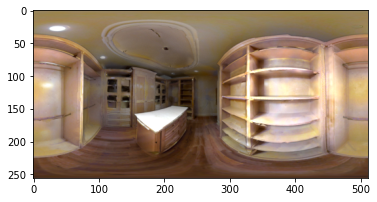

In [2]:
img = cv2.imread('pano4.png', cv2.IMREAD_COLOR)
#img = img.astype(np.float32) / 255
[erp_h, erp_w, _] = img.shape
plt.imshow(img[:,:,[2,1,0]])
plt.show()

In [3]:
img_new = img.astype(np.float32) / 255
img_new = np.transpose(img_new, [2, 0, 1])
img_new = torch.from_numpy(img_new)
img_new = img_new.unsqueeze(0)

In [4]:
height, width = 96, 96
FOV = [90, 90]
FOV = [FOV[0]/360.0, FOV[1]/180.0]
FOV = torch.tensor(FOV, dtype=torch.float32)
PI = math.pi
PI_2 = math.pi * 0.5
PI2 = math.pi * 2
yy, xx = torch.meshgrid(torch.linspace(0, 1, height), torch.linspace(0, 1, width))
screen_points = torch.stack([xx.flatten(), yy.flatten()], -1)

In [5]:
num_rows = 4
num_cols = [3, 6, 6, 3]
phi_centers = [-67.5, -22.5, 22.5, 67.5]
phi_interval = 180 // num_rows
all_combos = []
erp_mask = []
for i, n_cols in enumerate(num_cols):
    for j in np.arange(n_cols):
        theta_interval = 360 / n_cols
        theta_center = j * theta_interval + theta_interval / 2
        center = [theta_center, phi_centers[i]]
        all_combos.append(center)
        up = phi_centers[i] + phi_interval / 2
        down = phi_centers[i] - phi_interval / 2
        left = theta_center - theta_interval / 2
        right = theta_center + theta_interval / 2
        up = int((up + 90) / 180 * erp_h)
        down = int((down + 90) / 180 * erp_h)
        left = int(left / 360 * erp_w)
        right = int(right / 360 * erp_w)
        mask = np.zeros((erp_h, erp_w), dtype=int)
        mask[down:up, left:right] = 1
        erp_mask.append(mask)
all_combos = np.vstack(all_combos) 
shifts = np.arange(all_combos.shape[0]) * width
shifts = torch.from_numpy(shifts).float()
erp_mask = np.stack(erp_mask)
erp_mask = torch.from_numpy(erp_mask).float()
n_patch = all_combos.shape[0]

In [6]:
center_point = torch.from_numpy(all_combos).float()  # -180 to 180, -90 to 90
center_point[:, 0] = (center_point[:, 0]) / 360  #0 to 1
center_point[:, 1] = (center_point[:, 1] + 90) / 180  #0 to 1
cp = center_point * 2 - 1
cp[:, 0] = cp[:, 0] * PI
cp[:, 1] = cp[:, 1] * PI_2
cp = cp.unsqueeze(1)
convertedCoord = screen_points * 2 - 1
convertedCoord[:, 0] = convertedCoord[:, 0] * PI
convertedCoord[:, 1] = convertedCoord[:, 1] * PI_2
convertedCoord = convertedCoord * (torch.ones(screen_points.shape, dtype=torch.float32) * FOV)
convertedCoord = convertedCoord.unsqueeze(0).repeat(cp.shape[0], 1, 1)

In [7]:
x = convertedCoord[:, :, 0]
y = convertedCoord[:, :, 1]

rou = torch.sqrt(x ** 2 + y ** 2)
c = torch.atan(rou)
sin_c = torch.sin(c)
cos_c = torch.cos(c)
lat = torch.asin(cos_c * torch.sin(cp[:, :, 1]) + (y * sin_c * torch.cos(cp[:, :, 1])) / rou)
lon = cp[:, :, 0] + torch.atan2(x * sin_c, rou * torch.cos(cp[:, :, 1]) * cos_c - y * torch.sin(cp[:, :, 1]) * sin_c)
lat_new = lat / PI_2 
lon_new = lon / PI 
lon_new[lon_new > 1] -= 2
lon_new[lon_new<-1] += 2 

In [8]:
print(lon_new.shape, lat_new.shape)
lon_new = lon_new.view(1, n_patch, height, width).permute(0, 2, 1, 3).contiguous().view(height, n_patch*width)
lat_new = lat_new.view(1, n_patch, height, width).permute(0, 2, 1, 3).contiguous().view(height, n_patch*width)
grid = torch.stack([lon_new, lat_new], -1)

torch.Size([18, 9216]) torch.Size([18, 9216])


In [9]:
grid = grid.unsqueeze(0)
persp = F.grid_sample(img_new, grid, mode='bilinear', padding_mode='zeros', align_corners=True)
print(persp.shape)

torch.Size([1, 3, 96, 1728])


(96, 1728, 3)


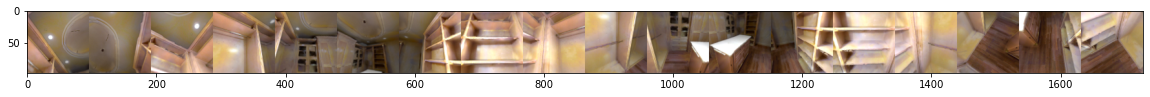

In [10]:
persp_int = persp[0].permute(1, 2, 0).numpy()
persp_int = persp_int * 255
cv2.imwrite('pers.png', persp_int.astype(np.uint8))
print(persp_int.shape)
plt.figure(figsize=(20, 12))
plt.imshow(persp_int[:,:,[2,1,0]].astype(np.uint8), aspect=1)
plt.show()

In [11]:
persp_reshape = F.unfold(persp, kernel_size=(height, width), stride=(height, width))
print(persp_reshape.shape)
persp_reshape = persp_reshape.reshape(1, 3, height, width, n_patch)
print(persp_reshape.shape)

torch.Size([1, 27648, 18])
torch.Size([1, 3, 96, 96, 18])


(96, 96, 3)


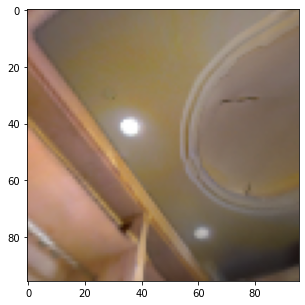

In [12]:
persp_patch = persp_reshape[0, :, :, :, 0].permute(1, 2, 0).numpy()
persp_patch = persp_patch * 255
print(persp_patch.shape)
plt.figure(figsize=(5, 5))
plt.imshow(persp_patch[:,:,[2,1,0]].astype(np.uint8), aspect=1)
plt.show()

In [13]:
lat_grid, lon_grid = torch.meshgrid(torch.linspace(-PI_2, PI_2, erp_h), torch.linspace(-PI, PI, erp_w))
lon_grid = lon_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1)
lat_grid = lat_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1) 

cos_c = torch.sin(cp[..., 1]) * torch.sin(lat_grid) + torch.cos(cp[..., 1]) * torch.cos(lat_grid) * torch.cos(lon_grid - cp[..., 0])
new_x = (torch.cos(lat_grid) * torch.sin(lon_grid - cp[..., 0])) / cos_c
new_y = (torch.cos(cp[..., 1])*torch.sin(lat_grid) - torch.sin(cp[...,1])*torch.cos(lat_grid)*torch.cos(lon_grid-cp[...,0])) / cos_c
new_x = new_x / FOV[0] / PI   # -1 to 1
new_y = new_y / FOV[1] / PI_2
print(cos_c.shape)
cos_c_mask = cos_c[0, ...].reshape(erp_h, erp_w)
cos_c_mask = torch.where(cos_c_mask > 0, 1, 0)

torch.Size([18, 131072])


In [14]:
new_x = (new_x[0, ...] + 1) * 0.5 * height
new_y = (new_y[0, ...] + 1) * 0.5 * width
new_x = new_x.reshape(erp_h, erp_w) 
new_y = new_y.reshape(erp_h, erp_w) 
mask = torch.where((new_x < width) & (new_x > 0) & (new_y < height) & (new_y > 0), 1, 0)
mask *= cos_c_mask


#new_x = new_x + shifts.reshape(-1, 1, 1)

In [15]:
one_patch = persp_reshape[..., 0]
new_x_remap = (new_x / width - 0.5) * 2
new_y_remap = (new_y / height - 0.5) * 2
new_grid = torch.stack([new_x_remap, new_y_remap], -1)
new_grid = new_grid.unsqueeze(0)
img_erp = F.grid_sample(one_patch, new_grid, mode='bilinear', padding_mode='zeros', align_corners=False)
img_erp *= mask.expand_as(img_erp)

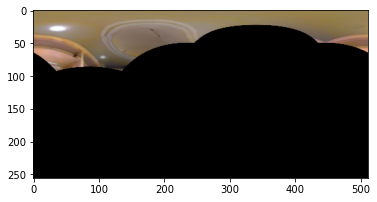

In [16]:
img_erp_int = img_erp[0].permute(1, 2, 0).numpy()
img_erp_int = img_erp_int * 255
img_erp_int = img_erp_int[:,:,[2,1,0]].astype(np.uint8)
plt.figure(figsize=(6, 6))
plt.imshow(img_erp_int, aspect=1)
plt.show()

In [17]:
#print(mask)
#new_x *= mask
#new_y *= mask
#new_x = new_x.unsqueeze(0)
#new_y = new_y.unsqueeze(0)
x0 = torch.floor(new_x).type(torch.int64)
x1 = x0 + 1
y0 = torch.floor(new_y).type(torch.int64)
y1 = y0 + 1

x0 = torch.clamp(x0, 0, width-1)
x1 = torch.clamp(x1, 0, width-1)
y0 = torch.clamp(y0, 0, height-1)
y1 = torch.clamp(y1, 0, height-1)

wa = (x1.type(torch.float32)-new_x) * (y1.type(torch.float32)-new_y)
wb = (x1.type(torch.float32)-new_x) * (new_y-y0.type(torch.float32))
wc = (new_x-x0.type(torch.float32)) * (y1.type(torch.float32)-new_y)
wd = (new_x-x0.type(torch.float32)) * (new_y-y0.type(torch.float32))
Ia = one_patch[:, :, y0, x0]
Ib = one_patch[:, :, y1, x0]
Ic = one_patch[:, :, y0, x1]
Id = one_patch[:, :, y1, x1]

Ia = Ia * mask.expand_as(Ia)
Ib = Ib * mask.expand_as(Ib)
Ic = Ic * mask.expand_as(Ic)
Id = Id * mask.expand_as(Id)

output = Ia * wa.expand_as(Ia) + Ib * wb.expand_as(Ib) + Ic * wc.expand_as(Ic) + Id * wd.expand_as(Id)


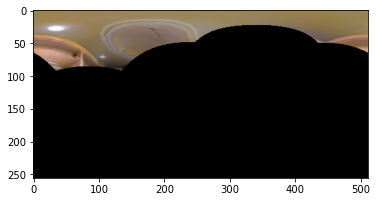

In [18]:
img_erp_int = output[0].permute(1, 2, 0).numpy()
img_erp_int = img_erp_int * 255
img_erp_int = img_erp_int[:,:,[2,1,0]].astype(np.uint8)
plt.figure(figsize=(6, 6))
plt.imshow(img_erp_int, aspect=1)
plt.show()